# Ice Load Data Rätan

In this notebook, data from ice panels at Rätan will be analyzed. The data is read from Google Drive. The spreadsheet should be manually filtered first so that the first row contains the name of the columns and the second row contains the unit of the data.

1. Import of Modules
2. Setup Work Directory
3. Import and Cleaning of Data
3. Visualization of Dataset


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import os
import glob
import inspect
import seaborn as sns
import datetime
# To visualize dataframes import display
from IPython.display import display
# Enable plotting inside the notebook
%matplotlib inline


# Setup Work Directory
Here, a link to Google Drive and Github is established together with the work directory to the data and to store plots. A list of all data is then created.

In [5]:
#### LINK GOOGLE DRIVE AND GITHUB

# Link Github Repository
!git clone https://github.com/AndreasSjolander/SVC-Research-School.git

# Create a data path
pa_data = 'SVC-Research-School/Task 3/Data'
pd_fig = 'SVC-Research-School/Task 3/Plot'

# Set the work directory
os.chdir(pa_data)
print (os.listdir())



fatal: destination path 'SVC-Research-School' already exists and is not an empty directory.
['Ice_load_raw_19-20.xlsx', 'Ice_load_raw_18-19.xlsx', 'Ice_load_raw_15-16.xlsx', 'Zero_recordings_ASJ.csv', 'Ice_load_raw_17-18.xlsx', 'Ice_load_raw_16-17.xlsx']


In [6]:
#### READ IN FILES WITH NEW NAME
# Find all files of specified type defined by: filetype
filetype = '*.xlsx'
Xlist = filetype
# Create an empty vector to store filenames in
filex = []
# Store all filenames defined above
for fx in glob.glob(Xlist, recursive=True):
    filex.append(fx)
print("A list of all files \n")
print(filex)


file2 = '*.csv'
Xlist_2 = file2
# Create an empty vector to store filenames in
zero_load = []
# Store all filenames defined above
for fx in glob.glob(Xlist_2, recursive=True):
    zero_load.append(fx)
print("A list of all files \n")
print(zero_load)

A list of all files 

['Ice_load_raw_19-20.xlsx', 'Ice_load_raw_18-19.xlsx', 'Ice_load_raw_15-16.xlsx', 'Ice_load_raw_17-18.xlsx', 'Ice_load_raw_16-17.xlsx']
A list of all files 

['Zero_recordings_ASJ.csv']


## 3. Importing and Cleaning of Data

Data is avaible in Excel format with a timestamp in the format:

1. Read in the data from Excel - OK
2. Clean the data
2a. Find row with HMB - OK
Drop other rows that contain text - OK
Set row with HMB to index - OK2
Drop columns that don't contain load or time - OK
Translate time-signal to time-date
Done!

In [7]:
###
# READ THE DATA TO PANDAS AND PLOT
###

"""
First, data is imported into a pandas data frame from Excel files. The data is
stacked on top of each other to create on data frame with all the data.
Thereafter, zero_readins are read into a data frame. This cotains the pre-tension
force on the panel and is used to calculate the load in each load cell.
"""

########################################
# 	Import data
########################################
# Date format
PARSER = lambda date: datetime.datetime.strptime(date, "%Y-%m-%d %H:%M:%S")

# Reading data
raw_data = pd.DataFrame()
for file in filex:
    raw_data_loc = pd.read_excel(
        file,
        index_col=0,
        header=0,
        date_parser=PARSER,
        na_values='NAN',
        )

    raw_data = pd.concat([raw_data, raw_data_loc], join='outer', sort=True, axis=0,)

raw_data.keys()

########################################
# 	Read Zero Readings for Season
########################################
PARSER = lambda date: datetime.datetime.strptime(date, "%Y-%m-%d")

zero_reading = pd.read_csv(
    zero_load[0],
    sep=",",
    index_col=0,
    header=0,
    date_parser=PARSER,
    na_values='NAN',
    )
print('This is the zero readings')
print(zero_reading)



<ipython-input-7-9fd5e7527def>:21: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  raw_data_loc = pd.read_excel(
<ipython-input-7-9fd5e7527def>:21: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  raw_data_loc = pd.read_excel(
<ipython-input-7-9fd5e7527def>:21: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  raw_data_loc = pd.read_excel(
<ipython-input-7-9fd5e7527def>:21: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dty

This is the zero readings
            Load_cell_1_zero  Load_cell_2_zero  Load_cell_3_zero  Scale
date                                                                   
2015-07-01           87.2500           103.900           117.000      1
2016-07-28           86.8400           103.530           117.340      1
2017-07-01           89.6500           106.000           123.600      1
2018-07-01            8.6810            10.432            11.210     10
2019-07-01            9.3610            10.493            11.702     10
2020-05-06            9.3287            10.449            11.699     10
2021-07-01           15.0640            10.223            11.136     10
2022-04-28          -95.5550            10.454            11.501     10
2023-11-10          -95.5500            10.525            11.267     10


<ipython-input-7-9fd5e7527def>:21: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  raw_data_loc = pd.read_excel(
<ipython-input-7-9fd5e7527def>:38: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  zero_reading = pd.read_csv(


# 4. Renaming and Removing
Below, the columns are first renamned and the data is calibrated to remove the zero readings from each years.

In [8]:
# RENAMING DATA
"""
The columns are renamned, the names of the columns is first extrated to a list
and then replaced with "new_name". Names in original columns must be unified.
Names of column is then replaced.
"""
raw_name = list(raw_data.columns.values)
new_name = ['Load_cell_1', 'Load_cell_2', 'Load_cell_3']

# Rename load cells
for name1, name2 in zip(raw_name, new_name):
    raw_data = raw_data.rename(columns={name1: name2})

print('This is the data with renamned columns')
print(raw_data.head(10))

# REMOVING ZERO LOADS
"""
Each load cell is pre-stressed to aorund 100 kN. The exact value in each cell
varies from year to year and is registred at the start of each season in
"zero_reading.csv". Also, the measured values have different scales which is alos
included in this file. The two dataframes are first joined, thereafter is the
load in each cell calcluated. Finally, the data is resampled to every hour and
exported as a .csv file
"""
# Join the meassurment data with the zero reading
new_data = pd.concat([raw_data, zero_reading], join='outer', sort=True, axis=0,)
new_data = new_data.sort_index()

# Fill zero reading
new_data = new_data.ffill()

print('- - - - - - -')
print('This is a summary of the data with zero-readings before filtering')
print(new_data.info())

# Create a empty data frame
load_data = pd.DataFrame()

# Substract zero reading
for (name, columnData) in raw_data.items():
    load_data[name] = (new_data[name] - new_data[name + '_zero']) * new_data['Scale']

# Remove the zero reading dates from the joint dataframe
for date in zero_reading.index:
    index_to_drop = load_data[load_data.index == date].iloc()
    load_data = load_data.drop(date)

# Drop duplicates on index, i.e. drop duplicated data
load_data = load_data[~load_data.index.duplicated(keep='first')]

print('- - - - - - -')
print('This is a summary of the data after drop duplicates')
print(load_data.info())


print('- - - - - - -')
print('This is the data with zero readings removed')
print(load_data.head(10))
print('- - - - - - -')
print('This is summary statistics over the data')
print(load_data.describe())



This is the data with renamned columns
                     Load_cell_1  Load_cell_2  Load_cell_3
2020-01-28 20:15:00    10.850927    12.156473    13.261440
2020-01-28 20:20:00    10.865508    12.165244    13.255611
2020-01-28 20:25:01    10.883005    12.171091    13.246867
2020-01-28 20:30:02    10.845095    12.150626    13.261440
2020-01-28 20:35:01    10.894669    12.176938    13.246867
2020-01-28 20:40:01    10.903418    12.179862    13.241038
2020-01-28 20:45:03    10.885921    12.168167    13.249781
2020-01-28 20:50:03    10.888837    12.165244    13.246867
2020-01-28 20:55:03    10.888837    12.168167    13.246867
2020-01-28 21:00:03    10.883005    12.159397    13.249781
- - - - - - -
This is a summary of the data with zero-readings before filtering
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365394 entries, 2015-07-01 00:00:00 to 2023-11-10 00:00:00
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   

#6 Calculating the Ice Load
Now, the ice load is calcluated. This is done based on experimental calibration performed in the laboratory before installation of the load panel.

In [9]:
# CALCULATION OF THE LOAD
load_data['Sum']=load_data.sum(axis=1).multiply(1.25)
print(load_data.head(10))
print('- - - - - - -')
print('This is summary statistics over the data')
print(load_data.describe())

                     Load_cell_1  Load_cell_2  Load_cell_3       Sum
2016-02-26 11:16:55    -4.111075     0.970775    -1.086272 -5.283215
2016-02-26 11:21:55    -4.111075     1.292375    -1.086272 -4.881216
2016-02-26 11:26:55    -4.140237     1.643211    -1.027980 -4.406257
2016-02-26 11:31:55    -3.877785     1.760157    -0.969688 -3.859145
2016-02-26 11:36:55    -3.819462     1.877102    -0.940542 -3.603628
2016-02-26 11:41:55    -3.761140     2.023284    -0.882250 -3.275132
2016-02-26 11:46:55    -1.778170     4.011355    -0.678228  1.943697
2016-02-26 11:51:55    -3.819462     2.169466    -0.765666 -3.019578
2016-02-26 11:56:55    -3.906946     2.052520    -0.794812 -3.311548
2016-02-26 12:01:55    -4.052753     1.964811    -0.794812 -3.603442
- - - - - - -
This is summary statistics over the data
         Load_cell_1    Load_cell_2    Load_cell_3            Sum
count  365385.000000  365385.000000  365385.000000  365385.000000
mean        4.631237       5.271415       3.517720    

# 7 Resampling of the Data

In [10]:
# Resamples data to hourely data
load_data_hour = load_data.resample('H').nearest(limit=1)

print('- - - - - - -')
print('This is summary statistics over the data BEFORE resampling')
print(load_data.describe())

print('- - - - - - -')
print('This is summary statistics over the data AFTER resampling')
print(load_data_hour.describe())

- - - - - - -
This is summary statistics over the data BEFORE resampling
         Load_cell_1    Load_cell_2    Load_cell_3            Sum
count  365385.000000  365385.000000  365385.000000  365385.000000
mean        4.631237       5.271415       3.517720      16.775465
std         6.063865       7.488289       6.218040      23.261992
min        -9.829526      -6.314348      -9.441180     -19.621427
25%         0.485657       0.642448       0.212300       1.962022
50%         2.473728       1.984370       1.174118       6.860282
75%         7.063835       7.100336       4.110866      26.242531
max        56.602794      67.220337      63.335581     205.931266
- - - - - - -
This is summary statistics over the data AFTER resampling
        Load_cell_1   Load_cell_2   Load_cell_3           Sum
count  16311.000000  16311.000000  16311.000000  16311.000000
mean       3.513905      3.525277      2.958687     12.497335
std        5.974848      6.550229      5.547385     20.967269
min       -9.

<ipython-input-10-82e093fe55ab>:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  load_data_hour = load_data.resample('H').nearest(limit=1)


#8. Plotting the data
Here, some plots are presented to illustrate the data

Some things to consider:
- Partial loss of data exist. Thus zero readins should be cleaned in some way.
 - Zero readings should be removed before defining a distribution

DatetimeIndex(['2016-02-26 11:16:55', '2016-02-26 11:21:55',
               '2016-02-26 11:26:55', '2016-02-26 11:31:55',
               '2016-02-26 11:36:55', '2016-02-26 11:41:55',
               '2016-02-26 11:46:55', '2016-02-26 11:51:55',
               '2016-02-26 11:56:55', '2016-02-26 12:01:55',
               ...
               '2020-07-03 09:58:02', '2020-07-03 10:03:01',
               '2020-07-03 10:08:01', '2020-07-03 10:13:02',
               '2020-07-03 10:18:02', '2020-07-03 10:23:01',
               '2020-07-03 10:28:01', '2020-07-03 10:33:01',
               '2020-07-03 10:38:02', '2020-07-03 10:43:02'],
              dtype='datetime64[ns]', length=365385, freq=None)
DatetimeIndex(['2020-01-28 20:15:00', '2020-01-28 20:20:00',
               '2020-01-28 20:25:01', '2020-01-28 20:30:02',
               '2020-01-28 20:35:01', '2020-01-28 20:40:01',
               '2020-01-28 20:45:03', '2020-01-28 20:50:03',
               '2020-01-28 20:55:03', '2020-01-28 21:00:03',
 

<Figure size 640x480 with 0 Axes>

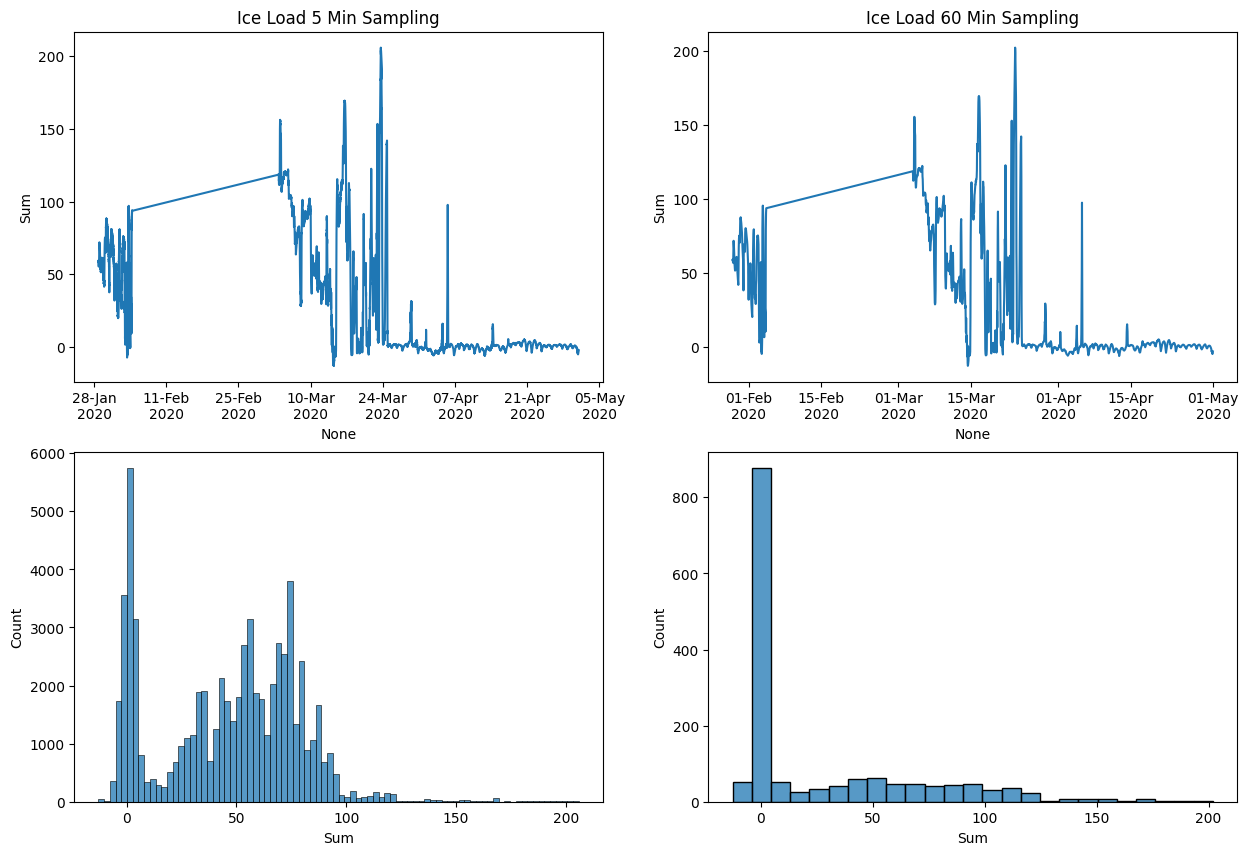

In [13]:
# FILTER DATA
"""  The data is filtered below. First, the index is set to datetime_index. To
    enable to filter on given dates. To subsets of data are produced:
    data_range = plots data from start_date to end_date
    data_year = plots data for a specific year
    data = original data
    data_hour = downsampled data for hours
"""

# DATASET 1
start_date = '2019-10-30'
end_date = '2020-04-30'

data = load_data.loc[start_date : end_date]
print(load_data.index)
print(data.index)

data_hour = load_data_hour.loc[start_date : end_date]
print(data_hour.index)


# Plot the strength of the concrete for different cement and binder content and wc ratios and age
plt.figure(1)
fig, ax1 = plt.subplots(2, 2, figsize=(15,10))
# Figure 1 Plot
sns.lineplot(data=data, x=data.index, y='Sum', ax=ax1[0,0])
ax1[0,0].set_title('Ice Load 5 Min Sampling')
# Figure 2 Plot
sns.lineplot(data=data_hour, x=data_hour.index, y='Sum', ax=ax1[0,1])
ax1[0,1].set_title('Ice Load 60 Min Sampling')

# Figure 3 Bar Plot
sns.histplot(data=data, x='Sum', ax=ax1[1,0])
# Figure 4 Bar Plot
sns.histplot(data=data_hour, x='Sum', ax=ax1[1,1])

# Format the x-axis of the first subplot
ax1[0,0].xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
fmt2 = mdates.DateFormatter('%d-%b\n%Y')
ax1[0,0].xaxis.set_major_formatter(fmt2)
ax1[0,1].xaxis.set_major_formatter(fmt2)


#ax1[1,0].set_title('Ice Load 5 Min Sampling')
# Figure 4 Bar Plot of Data
#sns.barplot(data=data_hour, x=data_hour.index, y='Sum', ax=ax1[1,1])
#ax1[1,1].set_title('Ice Load 60 Min Sampling')




plt.show()